In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import pickle
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lxml

### 00_Source: Labor Condition Application (LCA) data 
from the Department of Labor (DOL)

- Original Article: https://towardsdatascience.com/how-much-do-data-scientists-make-cbd7ec2b458
- Data source for this project: https://h1bdata.info/index.php
- Original data source: https://www.foreignlaborcert.doleta.gov/performancedata.cfm#dis

In [9]:
# links = ['https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+JOSE&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+CLARA&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SUNNYVALE&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MOUNTAIN+VIEW&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=CUPERTINO&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MENLO+PARK&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=PALO+ALTO&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDWOOD+CITY&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+MATEO&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+FRANCISCO&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SEATTLE&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDMOND&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+MONICA&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=LOS+ANGELES&year=All+Years',
#          'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=AUSTIN&year=All+Years',
#          'https://h1bdata.info/index.php?em=amazon&job=Data+Scientist+I&city=&year=All+Years'
#        ]

### 01_Links 
Extract all the data related to job `Data+Scientist` with no filter. There're a few way to cut the data at this point:
- job=Data+Scientist
- city=AUSTIN
- year=2019

Playing around the web page hosting this data, we can see a few titles related to `Data+Scientist` job. I'll explore the other titles in later analysis. 

In [5]:
# link to the entire db 
links = ['https://h1bdata.info/index.php?em=&job=Data+Scientist&city=&year=All+Years']

In [7]:
# Scrape table data from each of the above links and store in a list

jobs_list = []
for link in links:
    page_link = link
    page_response = requests.get(page_link, timeout=1000)
    page_content = BeautifulSoup(page_response.content, 'lxml')

    for row in page_content.find_all('tr')[1:]:
        row_data = []
        for i in row:
            row_data.append(i.text)
        jobs_list.append(row_data)

In [8]:
len(jobs_list)

7344

In [11]:
jobs_list[0:3]

[['PERCOLATA CORPORATION',
  'DATA SCIENTIST',
  '46,060',
  'PALO ALTO, CA',
  '03/18/2016',
  '09/02/2016',
  'CERTIFIED'],
 ['MY LIFE REGISTRY LLC',
  'DATA SCIENTIST',
  '47,960',
  'FORT LEE, NJ',
  '02/18/2015',
  '08/20/2015',
  'CERTIFIED'],
 ['MY LIFE REGISTRY LLC',
  'DATA SCIENTIST',
  '47,960',
  'FORT LEE, NJ',
  '02/18/2015',
  '08/20/2015',
  'CERTIFIED']]

### 02_ Create_Table

Data downloaded from web is a list of list hosting info for all h1b applicants. From sampling above we can see:
- i=0: company name
- i=1: title
- i=2: annual salary
- i=3: location
- i=4: applied date 

In [12]:
# Put everything into dataframes for easier processing

ds_jobs_df = pd.DataFrame()
ds_jobs_df['company'] = [i[0] for i in jobs_list]
ds_jobs_df['title'] = [i[1] for i in jobs_list]

ds_jobs_df['salary'] = [i[2].replace(',','') for i in jobs_list]
ds_jobs_df['salary'] = ds_jobs_df['salary'].astype(float)

ds_jobs_df['location'] = [i[3] for i in jobs_list]

ds_jobs_df['date'] = [i[4] for i in jobs_list]
ds_jobs_df['date'] = pd.to_datetime(ds_jobs_df['date'])
ds_jobs_df['year'] = [i.year for i in ds_jobs_df['date']]

In [13]:
ds_jobs_df.shape

(7344, 6)

In [14]:
ds_jobs_df.head()

,company,title,salary,location,date,year
0,PERCOLATA CORPORATION,DATA SCIENTIST,46060.0,"PALO ALTO, CA",2016-03-18,2016
1,MY LIFE REGISTRY LLC,DATA SCIENTIST,47960.0,"FORT LEE, NJ",2015-02-18,2015
2,MY LIFE REGISTRY LLC,DATA SCIENTIST,47960.0,"FORT LEE, NJ",2015-02-18,2015
3,BIG DATA ANALYTICS TRADING INC,DATA SCIENTIST,50000.0,"JOHNS CREEK, GA",2017-03-16,2017
4,YONO HEALTH INC,DATA SCIENTIST,50220.0,"SUNNYVALE, CA",2017-02-28,2017


### 03_Outliners

Filter out incomplete data by year and detect other gaps.

In [18]:
# data_by_year
ds_jobs_df[["year","title"]].groupby(["year"]).count()

,title
year,
2013,2
2014,74
2015,562
2016,909
2017,1286
2018,2179
2019,2332


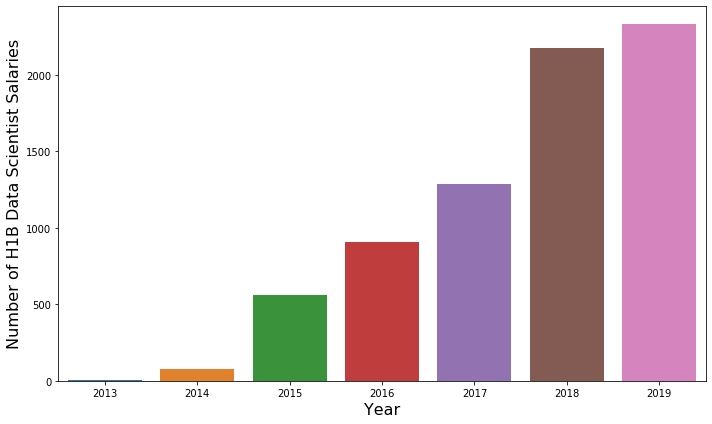

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=ds_jobs_df['year'].value_counts().sort_index().index, 
                 y=ds_jobs_df['year'].value_counts().sort_index().values)
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Number of H1B Data Scientist Salaries",fontsize=16)
plt.tight_layout()
plt.savefig(fname='num_jobs', dpi=150)

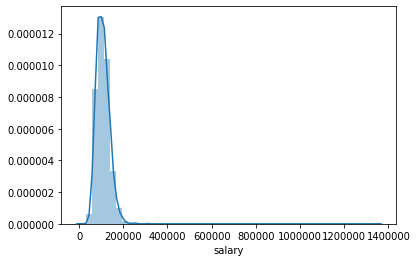

In [23]:
# distribution of salary

sns.distplot(ds_jobs_df['salary'])
# sns.distplot(ds_jobs_df['salary'], hist=False, rug=True);

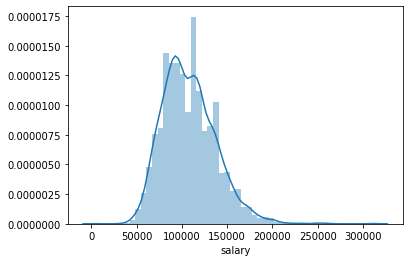

In [24]:
# if setting uppper bound at 400K
sns.distplot(ds_jobs_df[ds_jobs_df['salary']<400000]['salary'])

In [26]:
ds_jobs_df.sort_values(by=["salary"], ascending=False).head(10)

,company,title,salary,location,date,year
7343,AIRBNB INC,DATA SCIENTIST,1350001.0,"SAN FRANCISCO, CA",2015-02-12,2015
170,LARSON LIVING LABS LLC,DATA SCIENTIST,312000.0,"CAMBRIDGE, MA",2018-03-21,2018
171,LARSON LIVING LABS LLC,DATA SCIENTIST,312000.0,"CAMBRIDGE, MA",2018-05-14,2018
7341,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2019-04-09,2019
7340,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2018-12-10,2018
7342,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2019-05-24,2019
7339,AIRBNB INC,DATA SCIENTIST,253630.0,"SAN FRANCISCO, CA",2017-04-14,2017
7338,JDCOM AMERICAN TECHNOLOGIES CORPORATION,DATA SCIENTIST,250000.0,"SANTA CLARA, CA",2016-10-07,2016
7337,NEUBERGER BERMAN GROUP LLC,DATA SCIENTIST,250000.0,"NEW YORK, NY",2017-11-08,2017
7336,JDCOM AMERICAN TECHNOLOGIES CORPORATION,DATA SCIENTIST,248400.0,"MOUNTAIN VIEW, CA",2019-04-23,2019


From the above chart it's obvious filtering out 400K above is safe. 

In [19]:
# outliners

# Drop pre 2014 data (very few observations pre 2014)
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['year']<2014].index, axis=0, inplace=True)

# Drop salaries over $1,000,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']>1000000].index, axis=0, inplace=True)

# Sort by company and year
ds_jobs_df.sort_values(by=['year','company'], inplace=True, ascending=True)

In [20]:
ds_jobs_df.shape

(332, 6)

In [22]:
ds_jobs_df['salary'].median()

120000.0

In [26]:
median_salary = ds_jobs_df.groupby(by=['year']).median().reset_index()
median_salary

,year,salary
0,2014,120000.0
1,2015,117846.5
2,2016,120000.0
3,2017,120000.0
4,2018,120000.0
5,2019,110004.0


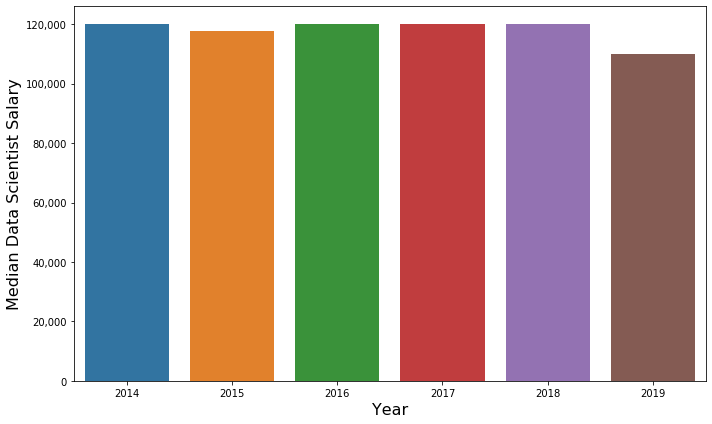

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=median_salary['year'], 
                 y=median_salary['salary'])
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Median Data Scientist Salary",fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.savefig(fname='median_salary', dpi=150)